# Data research on PTB dataset

first inspect:  
1.know dataset status: target value, columns, duplicated, missing value   
2.plot different data rows to have the first inspect of heartbeat shape.

Research on PTB dataset for future preprocessing:  
Try to apply the PCA etc.. to identify significant features.   
Try several model to find the best rescaling method and resampling method.  

# **Check enviroment**

Set data_path to make notebooks works well both on local and google drive.

In [1]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'ptbdb_normal': data_path +  'ptbdb_normal.csv',
    'ptbdb_abnormal':  data_path + 'ptbdb_abnormal.csv',
})

Running on local environment
Current working directory: /Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/notebooks


# **Import packages:**

In [2]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [3]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df

def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """
    plt.figure(figsize=(10, 6))
    bar_chart = category_value_counts.plot(kind='bar')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=360)
    for i in bar_chart.containers:
        bar_chart.bar_label(i, label_type='edge')
    plt.show()


def showTop10DataInChart(df):
    plt.figure(figsize=(10, 6))
    xDataAxis = list(range(0, df.shape[1]))
    yDataRows = list(df.values[1: 10])
    for y in yDataRows:
        plt.plot(xDataAxis, y)
    plt.show()

In [4]:
ptbdb_normal = pd.read_csv(Path.get('ptbdb_normal'), header=None ) 
ptbdb_normal_with_columns = addColumnsToDataframe(ptbdb_normal) # add columns to the dataframe
ptbdb_normal_with_columns = convertColumnAsInt(ptbdb_normal_with_columns, 'target') # convert the target column to int

In [5]:
ptbdb_normal_with_columns # Normal in target = 0 !!!!

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
ptbdb_abnormal = pd.read_csv(Path.get('ptbdb_abnormal'), header=None ) 
ptbdb_abnormal_with_columns = addColumnsToDataframe(ptbdb_abnormal) # add columns to the dataframe
ptbdb_abnormal_with_columns = convertColumnAsInt(ptbdb_abnormal_with_columns, 'target') # convert the target column to int

In [7]:
ptbdb_abnormal_with_columns ## Abnormal in target = 1 !!!!

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Merge normal and abnomal data to one dataset and shuffle it

In [8]:
#Merge the datasets
ptbdb = pd.concat([ptbdb_abnormal_with_columns, ptbdb_normal_with_columns], ignore_index=True) # ingore the index to make the index continuous
#Shuffle the dataset
ptbdb = ptbdb.sample(frac=1).reset_index(drop=True)
ptbdb

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
0,1.000000,0.792931,0.523385,0.364513,0.251339,0.167440,0.131025,0.126740,0.114959,0.096394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.995882,0.294412,0.110588,0.145000,0.138824,0.128235,0.116176,0.112353,0.108529,0.107941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.950746,0.513433,0.329851,0.323881,0.049254,0.068657,0.049254,0.035821,0.056716,0.017910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.000000,0.744136,0.600746,0.319829,0.272388,0.201493,0.179638,0.188699,0.176972,0.153518,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1.000000,0.516636,0.159105,0.405324,0.517241,0.413188,0.330309,0.268603,0.238959,0.256503,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.920259,0.924928,0.700431,0.368534,0.122845,0.000000,0.050287,0.114224,0.104167,0.103448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
14548,1.000000,0.413068,0.291805,0.037099,0.023256,0.158361,0.373754,0.446844,0.408084,0.471207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14549,0.977295,0.903258,0.361303,0.153011,0.051333,0.200395,0.308983,0.340573,0.365252,0.347483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
14550,0.936888,0.348205,0.046790,0.063112,0.186072,0.281828,0.322089,0.347116,0.338411,0.361262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [9]:
#Split the data into training (80%) and testing (20%)
from sklearn.model_selection import train_test_split
ptbdb_train, ptbdb_test = train_test_split(ptbdb, test_size=0.2, random_state=42)


In [10]:
#train:
print(ptbdb_train.shape)
print("The train data has 11.641 and 188 columns.")

#test:
print(ptbdb_test.shape)
print("The test data has 2.911 and 188 columns.")

(11641, 188)
The train data has 11.641 and 188 columns.
(2911, 188)
The test data has 2.911 and 188 columns.


In [11]:
print(ptbdb_train["target"])
print(ptbdb_test["target"])

4292     0
8963     0
10671    0
8994     1
13691    0
        ..
5191     1
13418    1
5390     0
860      1
7270     1
Name: target, Length: 11641, dtype: int64
2069     1
6174     0
11676    1
5407     1
11090    1
        ..
12476    0
11461    1
11360    0
3958     1
5440     1
Name: target, Length: 2911, dtype: int64


In [12]:
print(ptbdb_train.dtypes)
print(ptbdb_test.dtypes)
print("The features are numeric. All columns have the type float64, while the target column is int32.")

c_0       float64
c_1       float64
c_2       float64
c_3       float64
c_4       float64
           ...   
c_183     float64
c_184     float64
c_185     float64
c_186     float64
target      int64
Length: 188, dtype: object
c_0       float64
c_1       float64
c_2       float64
c_3       float64
c_4       float64
           ...   
c_183     float64
c_184     float64
c_185     float64
c_186     float64
target      int64
Length: 188, dtype: object
The features are numeric. All columns have the type float64, while the target column is int32.


In [13]:
print(ptbdb_test.info(show_counts=True), end="\n\n")
print("Size of the DataFrame", ptbdb_test.shape, end='\n\n')

print(ptbdb_train.info(show_counts=True), end="\n\n")
print("Size of the DataFrame", ptbdb_train.shape, end='\n\n')

<class 'pandas.core.frame.DataFrame'>
Index: 2911 entries, 2069 to 5440
Columns: 188 entries, c_0 to target
dtypes: float64(187), int64(1)
memory usage: 4.2 MB
None

Size of the DataFrame (2911, 188)

<class 'pandas.core.frame.DataFrame'>
Index: 11641 entries, 4292 to 7270
Columns: 188 entries, c_0 to target
dtypes: float64(187), int64(1)
memory usage: 16.8 MB
None

Size of the DataFrame (11641, 188)



Remove duplicates

In [11]:
nb_rows_duplicated = ptbdb_train.duplicated().sum()
print("Number of rows duplicated :", nb_rows_duplicated)

nb_rows_duplicated = ptbdb_test.duplicated().sum()
print("Number of rows duplicated :", nb_rows_duplicated)

Number of rows duplicated : 5
Number of rows duplicated : 0


In [12]:
# Remove duplicates from the training set
ptbdb_train = ptbdb_train.drop_duplicates()

# Remove duplicates from the testing set
ptbdb_test = ptbdb_test.drop_duplicates()

# Verify the removal by checking the number of duplicated rows again
nb_rows_duplicated_train = ptbdb_train.duplicated().sum()
print("Number of rows duplicated in train set after removal:", nb_rows_duplicated_train)

nb_rows_duplicated_test = ptbdb_test.duplicated().sum()
print("Number of rows duplicated in test set after removal:", nb_rows_duplicated_test)


Number of rows duplicated in train set after removal: 0
Number of rows duplicated in test set after removal: 0


In [16]:
print("Missing values in train:", ptbdb_train.isnull().sum())
print("Missing values in test:", ptbdb_test.isnull().sum())
print("The data has no missing values.")

Missing values in train: c_0       0
c_1       0
c_2       0
c_3       0
c_4       0
         ..
c_183     0
c_184     0
c_185     0
c_186     0
target    0
Length: 188, dtype: int64
Missing values in test: c_0       0
c_1       0
c_2       0
c_3       0
c_4       0
         ..
c_183     0
c_184     0
c_185     0
c_186     0
target    0
Length: 188, dtype: int64
The data has no missing values.


In [17]:
ptbdb_train.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
4292,1.0,0.968862,0.576951,0.261990,0.051181,0.000000,0.052613,0.086614,0.083035,0.082677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8963,1.0,0.768515,0.186627,0.034278,0.086754,0.146424,0.132036,0.117224,0.114262,0.120186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10671,1.0,0.215018,0.000000,0.034469,0.018465,0.077554,0.102175,0.112844,0.114485,0.111613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8994,1.0,0.635985,0.179407,0.066563,0.122205,0.114405,0.160686,0.158606,0.158086,0.130005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
13691,1.0,0.523722,0.299007,0.064730,0.000000,0.057006,0.111438,0.110702,0.110702,0.117323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
ptbdb_test.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_178,c_179,c_180,c_181,c_182,c_183,c_184,c_185,c_186,target
2069,1.000000,0.939024,0.820461,0.768970,0.486450,0.178184,0.074526,0.000000,0.096883,0.198509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6174,0.964624,0.821884,0.296586,0.051419,0.051831,0.111065,0.125463,0.114768,0.109831,0.109831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
11676,1.000000,0.873365,0.439952,0.076694,0.079073,0.199168,0.197384,0.215815,0.168847,0.196195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5407,1.000000,0.913867,0.869078,0.788975,0.727821,0.684755,0.620155,0.546942,0.513351,0.498708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
11090,0.958757,0.612429,0.266667,0.000000,0.071186,0.150282,0.156497,0.158192,0.157627,0.150282,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Visualize Target 

In [17]:
# Define mapping dictionary
class_mapping = {
    1: 'Abnormal',
    0: 'Normal',
}

# Define custom colors for each category
color_mapping = {
    1: 'red',      # Abnormal beat 
    0: 'green',    # Normal beat
}

classes_to_plot = [0, 1]

# Calculate value counts based on mapped class names
value_counts_series_train = ptbdb_train['target'].map(class_mapping).value_counts()
# Calculate value counts based on mapped class names
value_counts_series_test = ptbdb_test['target'].map(class_mapping).value_counts()

In [18]:
print("Training Dataset Class Distribution:")
print(value_counts_series_train)

print("\nTesting Dataset Class Distribution:")
print(value_counts_series_test)

Training Dataset Class Distribution:
target
Abnormal    8402
Normal      3234
Name: count, dtype: int64

Testing Dataset Class Distribution:
target
Abnormal    2100
Normal       811
Name: count, dtype: int64


Barplots and Piecharts

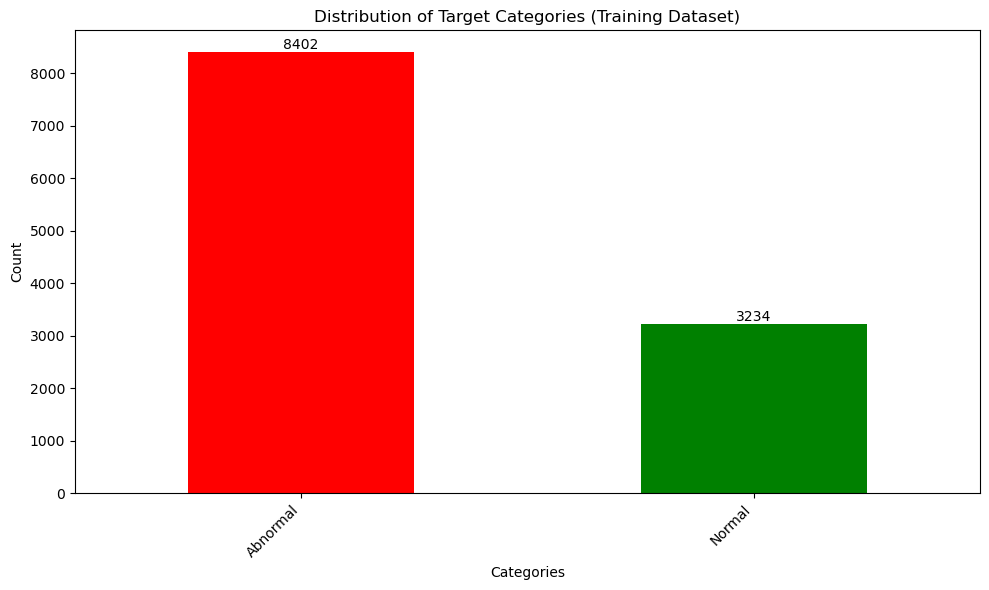

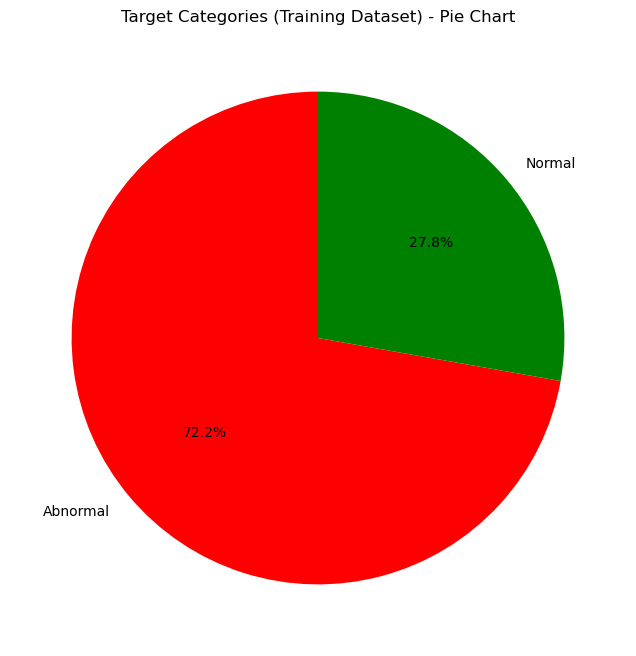

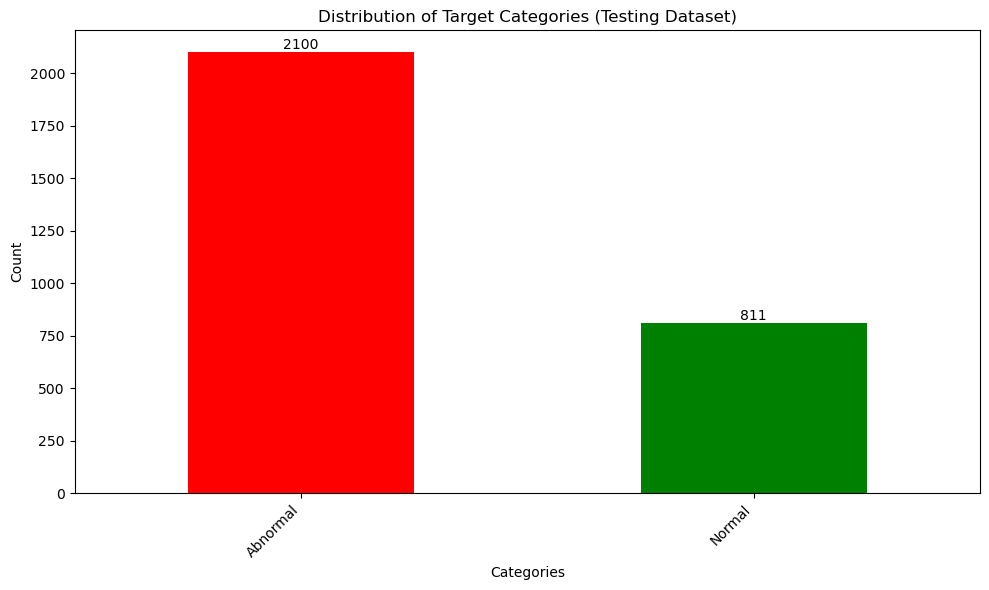

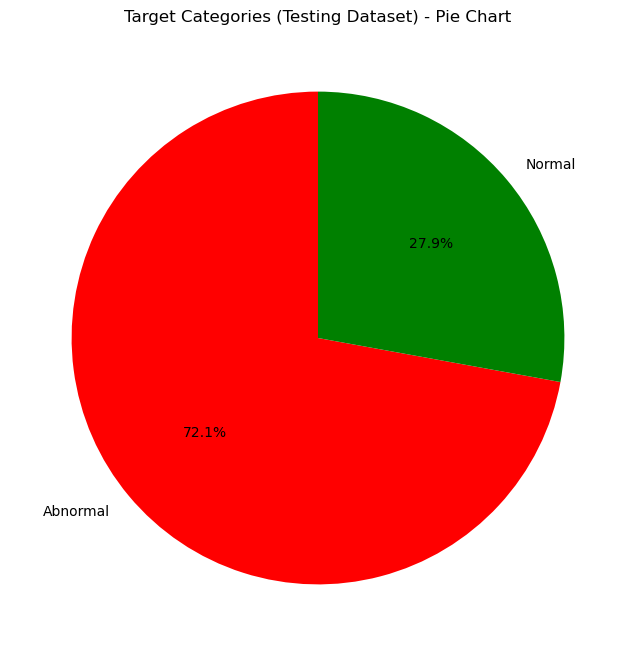

In [19]:
import matplotlib.pyplot as plt

# Bar chart for the training dataset
plt.figure(figsize=(10, 6))
bar_chart_train = value_counts_series_train.plot(kind='bar', color=color_mapping.values())
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Target Categories (Training Dataset)')
plt.xticks(rotation=45, ha='right')

# Add labels to the bars in the training set
for container in bar_chart_train.containers:
    plt.bar_label(container, label_type='edge')

plt.tight_layout()
plt.show()

# Pie chart for the training dataset
plt.figure(figsize=(8, 8))  # Set figure size
value_counts_series_train.plot(kind='pie', autopct='%1.1f%%', colors=color_mapping.values(), startangle=90)
plt.ylabel('')  # Remove the y-label
plt.title('Target Categories (Training Dataset) - Pie Chart')
plt.show()

# Bar chart for the testing dataset
plt.figure(figsize=(10, 6))
bar_chart_test = value_counts_series_test.plot(kind='bar', color=color_mapping.values())
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Target Categories (Testing Dataset)')
plt.xticks(rotation=45, ha='right')

# Add labels to the bars in the testing set
for container in bar_chart_test.containers:
    plt.bar_label(container, label_type='edge')

plt.tight_layout()
plt.show()

# Pie chart for the testing dataset
plt.figure(figsize=(8, 8))  # Set figure size
value_counts_series_test.plot(kind='pie', autopct='%1.1f%%', colors=color_mapping.values(), startangle=90)
plt.ylabel('')  # Remove the y-label
plt.title('Target Categories (Testing Dataset) - Pie Chart')
plt.show()


Plot of each class once

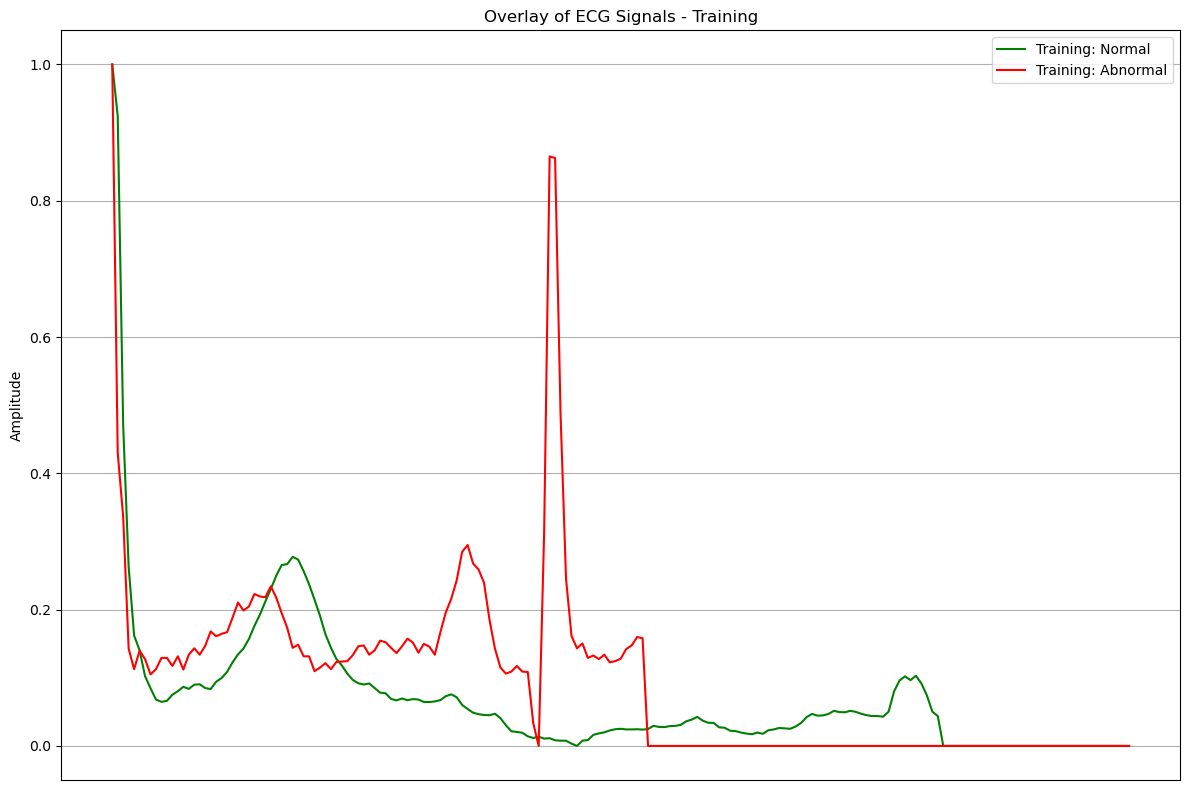

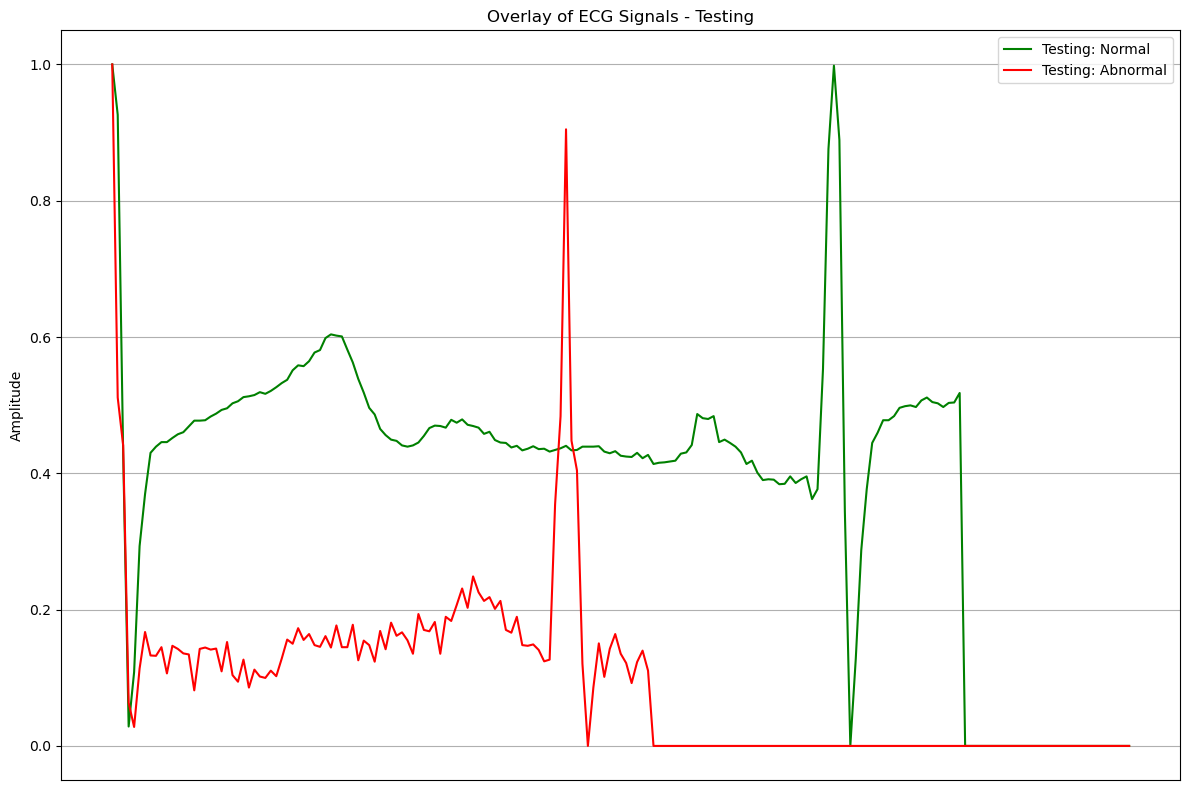

In [23]:
# Function to plot overlay of ECG signals from both datasets for a single class
def plot_overlay_ecg_signals(df, label, color, dataset_label): # Define a function to plot overlay of ECG signals for a single class from both datasets
    """
    Plot overlay of ECG signals for a single class from both datasets.

    Parameters:
    df (DataFrame): DataFrame containing ECG signals and target labels
    label (str or int): Class label to plot
    color (str): Color for the plot
    dataset_label (str): Label for the dataset (e.g., 'Training', 'Testing')
    """

    # Map the descriptive label to the corresponding class label
    if isinstance(label, str):
        class_label = [k for k, v in class_mapping.items() if v == label][0] # Get the class label for the specified class name
    else:
        class_label = label # Use the specified class label
    
    # Extract data rows for the specified class label
    class_data = df[df['target'] == class_label]

    # Check if there is any data for the specified class label
    if class_data.empty:
        print(f"No data found for class {class_mapping[class_label]}")
        return
    
    # Extract a sample data row (first row) for the specified class label
    sample_data = class_data.iloc[0]

    # Plot the sample ECG signal, excluding the 'target' column
    plt.plot(sample_data[:-1], label=f'{dataset_label}: {class_mapping[class_label]}', color=color)

    plt.title(f"Overlay of ECG Signals - {dataset_label}")
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.xticks([])  # Remove x-axis ticks and labels
    plt.legend()

# List of classes to plot
classes_to_plot = [0, 1]


# Colors for each class
colors = ['green','red']


# Plotting overlay for each class in both datasets
plt.figure(figsize=(12, 8))

# Plotting for training dataset
for label, color in zip(classes_to_plot, colors):
    plot_overlay_ecg_signals(ptbdb_train, label, color, 'Training')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

# Plotting for testing dataset
for label, color in zip(classes_to_plot, colors):
    plot_overlay_ecg_signals(ptbdb_test, label, color, 'Testing')

plt.tight_layout()
plt.show()

# Perform Histogram

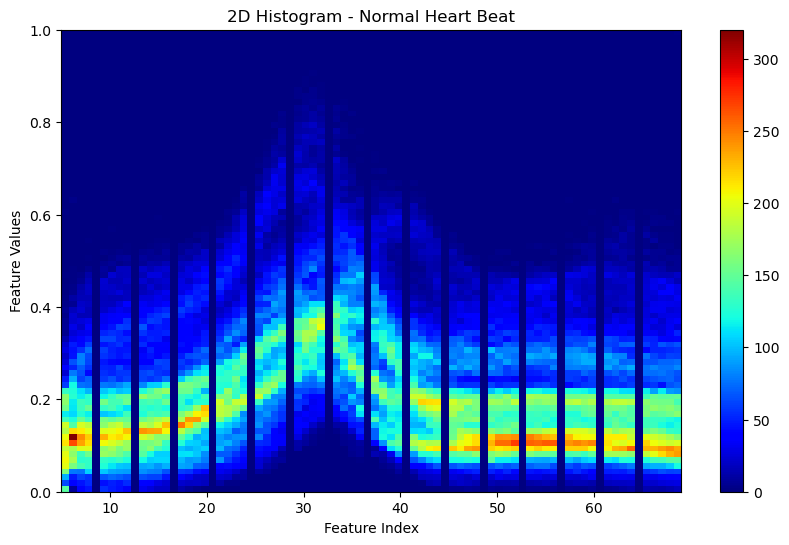

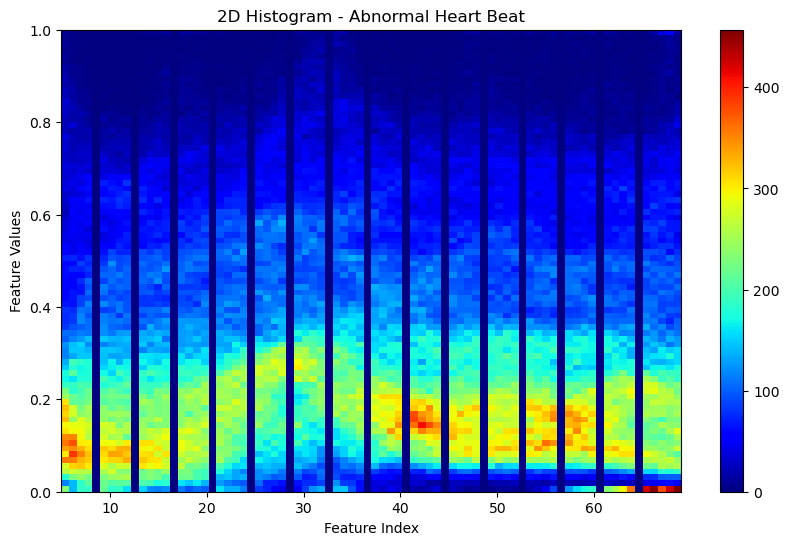

In [24]:
def plot_hist(class_name, min_val=5, size=70, title=''):
    # Map the descriptive label to the corresponding class label
    if isinstance(class_name, str):
        class_label = [k for k, v in class_mapping.items() if v == class_name][0]  # Convert class name to class label 
    else:
        class_label = class_name  # Use the specified class label directly if it's already a number
    
    # Filter the dataset based on the class_label
    img = ptbdb_train.loc[ptbdb_train['target'] == class_label].iloc[:, min_val:size]
    
    # Flatten the array
    img_flatten = img.values.flatten()
    
    # Generate corresponding x-values for the histogram
    x_values = np.tile(np.arange(min_val, size), img.shape[0])
    
    # Ensure that the lengths match for histogram plotting
    assert len(x_values) == len(img_flatten), "Mismatch in lengths of x-values and flattened image values."
    
    # Create the 2D histogram
    plt.figure(figsize=(10, 6))
    plt.hist2d(x_values, img_flatten, bins=(80, 80), cmap=plt.cm.jet)
    plt.colorbar()  # Add a color bar to indicate the intensity of values
    plt.title('2D Histogram - ' + title)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Values')
    plt.show()

# Plot for Normal Heart Beat
plot_hist(0, title='Normal Heart Beat')

# Plot for Abnormal Heart Beat
plot_hist(1, title='Abnormal Heart Beat')


# PCA Functions for training Dataset

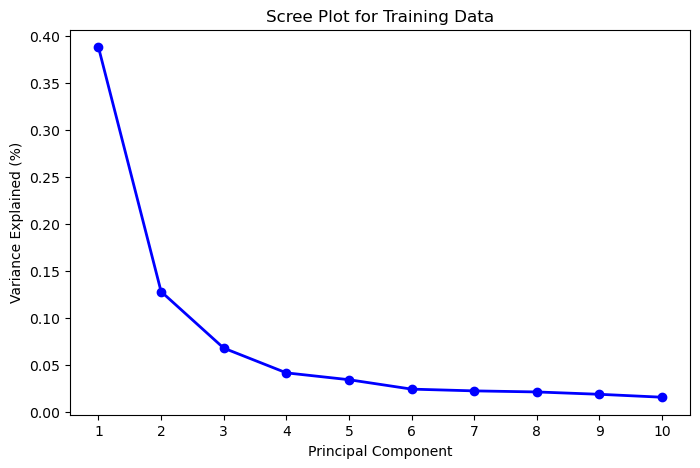

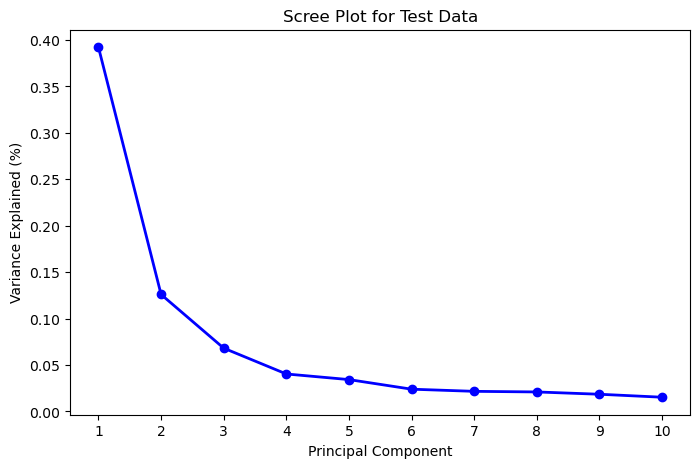

In [25]:
# Define the function to apply PCA
def apply_pca_to_dataset(df, n_components=2):
    X = df.drop('target', axis=1)
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X)
    df_pca = pd.DataFrame(data=components, columns=[f'Principal Component {i+1}' for i in range(n_components)])
    df_pca['target'] = df['target']
    return df_pca, pca

# Define the function to plot PCA results (2D)
def plot_pca_results(df_pca, title='PCA of Dataset'):
    # Define custom colors and labels for each category
    color_mapping = {0: 'green', 1: 'red'}
    label_mapping = {0: 'Normal', 1: 'Abnormal'}
    
    # Map the target to the corresponding colors and labels
    df_pca['color'] = df_pca['target'].map(color_mapping)
    df_pca['label'] = df_pca['target'].map(label_mapping)

    # Create a scatter plot for the PCA results
    fig = px.scatter(df_pca, x='Principal Component 1', y='Principal Component 2', color='label',
                     color_discrete_map={'Normal': 'green', 'Abnormal': 'red'},
                     title=title, labels={'label': 'Class'}, opacity=0.5)
    fig.update_traces(marker=dict(size=5))
    fig.show()

# Define the function to create a Scree plot
def create_scree_plot(pca, title='Scree Plot'):
    explained_var_ratio = pca.explained_variance_ratio_
    components = np.arange(len(explained_var_ratio)) + 1

    plt.figure(figsize=(8, 5))
    plt.plot(components, explained_var_ratio, 'o-', linewidth=2, color='blue')
    plt.title(title)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained (%)')
    plt.xticks(components)
    plt.show()

# Apply PCA to the training dataset for 10 components to create the Scree plot
df_pca_train, pca_train = apply_pca_to_dataset(ptbdb_train, n_components=10)
create_scree_plot(pca_train, title='Scree Plot for Training Data')

# Apply PCA to the training dataset for 2 components and plot the 2D PCA results
df_pca_train, pca_train = apply_pca_to_dataset(ptbdb_train, n_components=2)
plot_pca_results(df_pca_train, title='PCA of Heartbeat Dataset (2D) - Training Data')

# Apply PCA to the training dataset for 3 components and plot the 3D PCA results
df_pca_train, pca_train = apply_pca_to_dataset(ptbdb_train, n_components=3)
df_pca_train['color'] = df_pca_train['target'].map({0: 'red', 1: 'green'})
df_pca_train['label'] = df_pca_train['target'].map({0: 'Abnormal', 1: 'Normal'})

fig = px.scatter_3d(df_pca_train, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                    color='label',
                    color_discrete_map={'Normal': 'green', 'Abnormal': 'red'},
                    title='3D PCA of Heartbeat Dataset - Training Data',
                    labels={'label': 'Class'}, opacity=0.5)
fig.update_traces(marker=dict(size=5))
fig.show()

# Apply PCA to the test dataset for 10 components to create the Scree plot
df_pca_test, pca_test = apply_pca_to_dataset(ptbdb_test, n_components=10)
create_scree_plot(pca_test, title='Scree Plot for Test Data')

# Apply PCA to the test dataset for 2 components and plot the 2D PCA results
df_pca_test, pca_test = apply_pca_to_dataset(ptbdb_test, n_components=2)
plot_pca_results(df_pca_test, title='PCA of Heartbeat Dataset (2D) - Test Data')

# Apply PCA to the test dataset for 3 components and plot the 3D PCA results
df_pca_test, pca_test = apply_pca_to_dataset(ptbdb_test, n_components=3)
df_pca_test['color'] = df_pca_test['target'].map({0: 'red', 1: 'green'})
df_pca_test['label'] = df_pca_test['target'].map({0: 'Abnormal', 1: 'Normal'})

fig = px.scatter_3d(df_pca_test, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
                    color='label',
                    color_discrete_map={'Normal': 'green', 'Abnormal': 'red'},
                    title='3D PCA of Heartbeat Dataset - Test Data',
                    labels={'label': 'Class'}, opacity=0.5)
fig.update_traces(marker=dict(size=5))
fig.show()



# Look at the loadings to determine which variables are most significant in each principal component in training data set

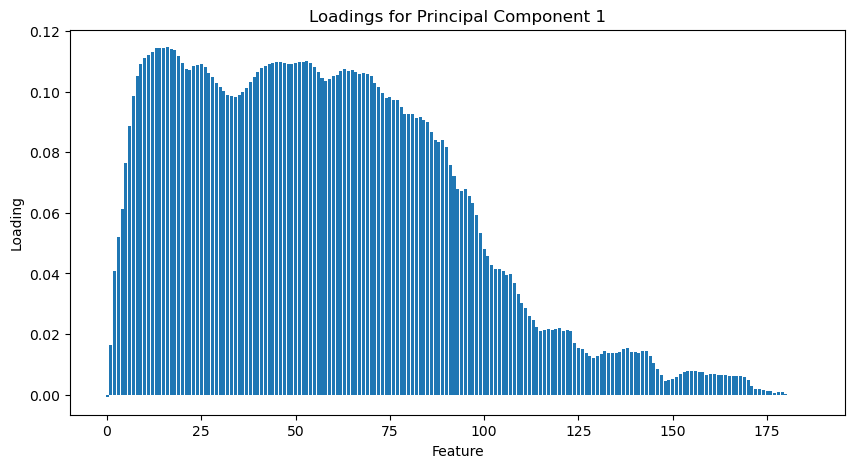

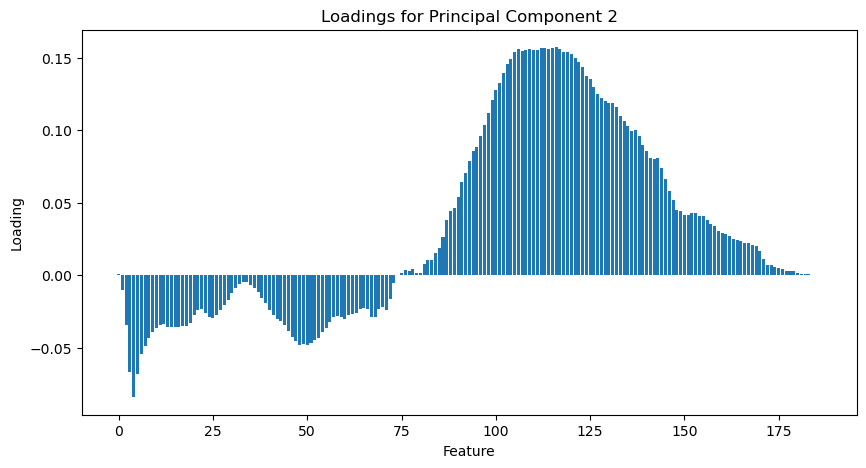

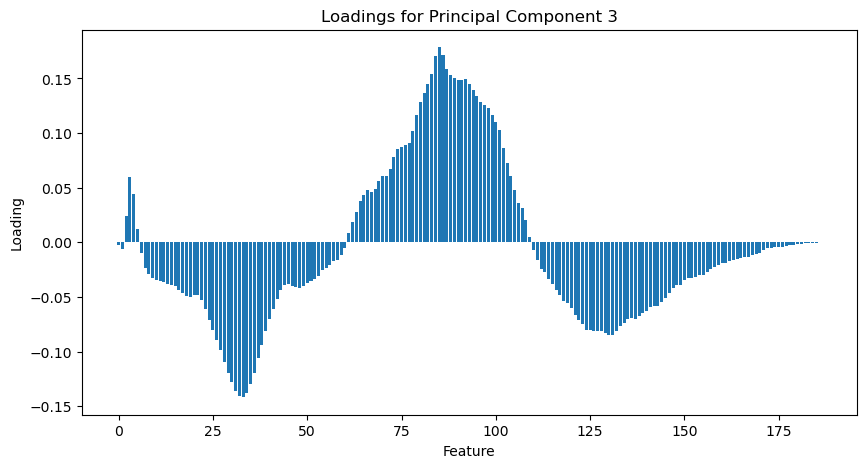

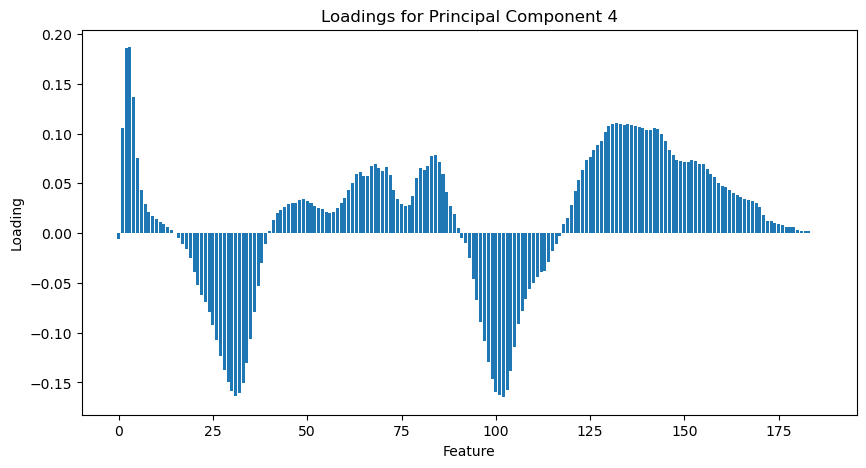

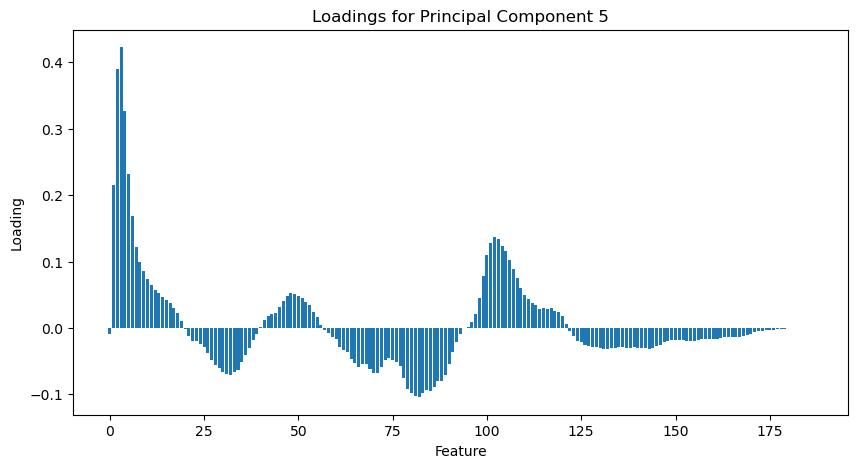

In [25]:
# train
df_pca, pca = apply_pca_to_dataset(ptbdb_train, n_components=5)

loadings = pca.components_ # Get the loadings for the principal components (eigenvectors)

for i, component in enumerate(loadings):

    plt.figure(figsize=(10, 5))


    plt.bar(x=range(len(component)), height=component)


    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.title(f'Loadings for Principal Component {i+1}')

    plt.show()

In [26]:
df_pca

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,target
0,-1.174226,0.023806,-0.234140,-0.176560,0.128687,1.0
1,-1.270305,0.257272,-0.685985,-0.172467,-0.121283,1.0
2,-0.867512,0.539593,0.028968,-0.197593,-0.292073,1.0
3,-0.766554,0.046736,0.022521,-0.400467,-0.025291,1.0
4,-1.324279,0.563090,-0.299168,-0.031293,-0.011418,1.0
...,...,...,...,...,...,...
11630,0.538467,0.620706,0.040606,-0.300518,-0.198490,1.0
11631,5.088917,2.258323,0.343177,0.403018,0.983028,NaN
11632,-2.050271,0.444741,-0.511684,-0.117969,-0.177868,1.0
11633,0.423728,-0.922103,0.008751,0.350774,0.105469,NaN


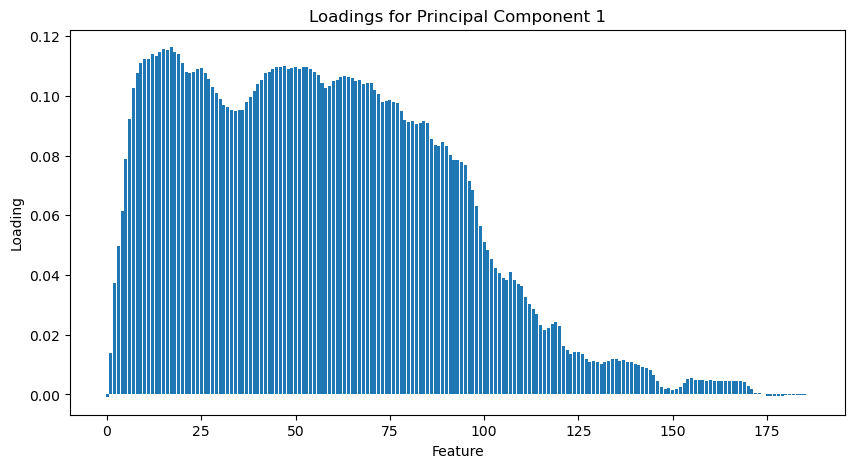

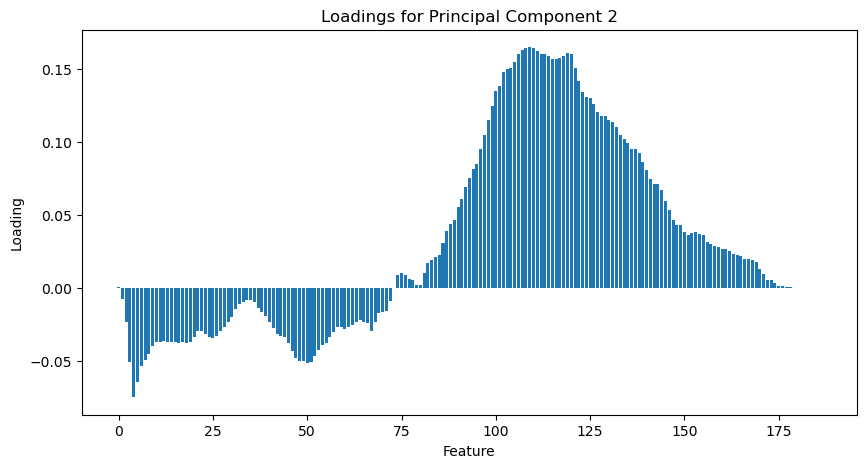

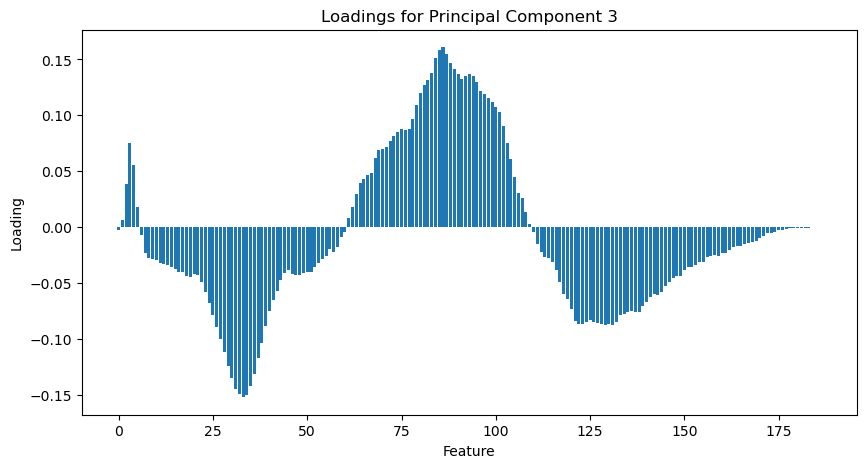

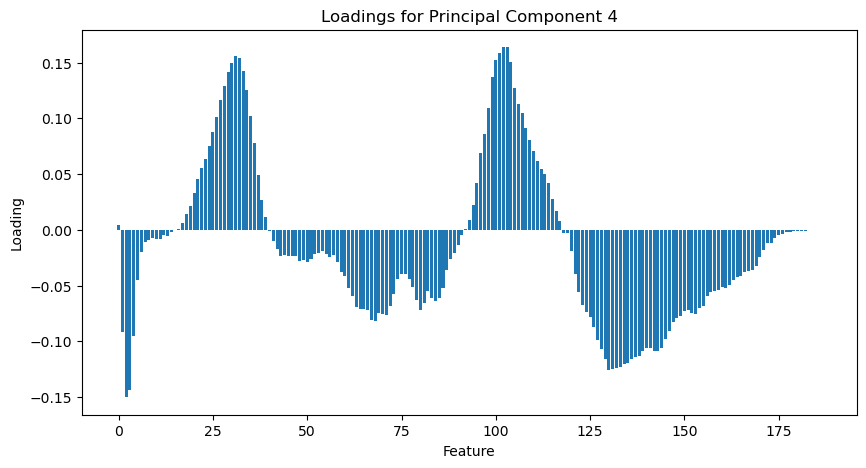

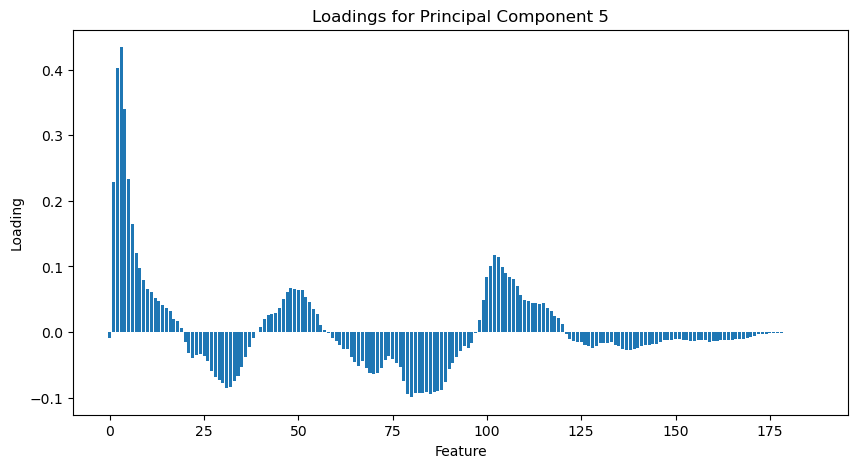

In [27]:
# test
df_pca, pca = apply_pca_to_dataset(ptbdb_test, n_components=5)


loadings = pca.components_


for i, component in enumerate(loadings):

    plt.figure(figsize=(10, 5))


    plt.bar(x=range(len(component)), height=component)


    plt.xlabel('Feature')
    plt.ylabel('Loading')
    plt.title(f'Loadings for Principal Component {i+1}')

    plt.show()

# Identify significant features

In [28]:
from scipy.stats import f_oneway, kruskal
# Separate features and labels
features = ptbdb_train.iloc[:, :-1]
labels = ptbdb_train['target']

p_values = []

for i in range(features.shape[1]):

    class_groups = [features[labels == label].iloc[:, i] for label in class_mapping.values()]

    # If not normally distributed, use Kruskal-Wallis H-test
    h_stat, p_val = kruskal(*class_groups)
    p_values.append(p_val)


adjusted_p_values = [p * len(p_values) for p in p_values]

# Select features with p-value below the significance level
significant_features = [i for i, p_val in enumerate(adjusted_p_values) if p_val < 0.05]

print(f'Number of significant features: {len(significant_features)}')
# print(f'Significant features: {significant_features}')

print('The absence of significant features suggests that the classes may not be well-separated in the original feature space,\n which could make it challenging for PCA and t-SNE to clearly distinguish between them.')

Number of significant features: 0
The absence of significant features suggests that the classes may not be well-separated in the original feature space,
 which could make it challenging for PCA and t-SNE to clearly distinguish between them.


# Perform t_SNE in training set

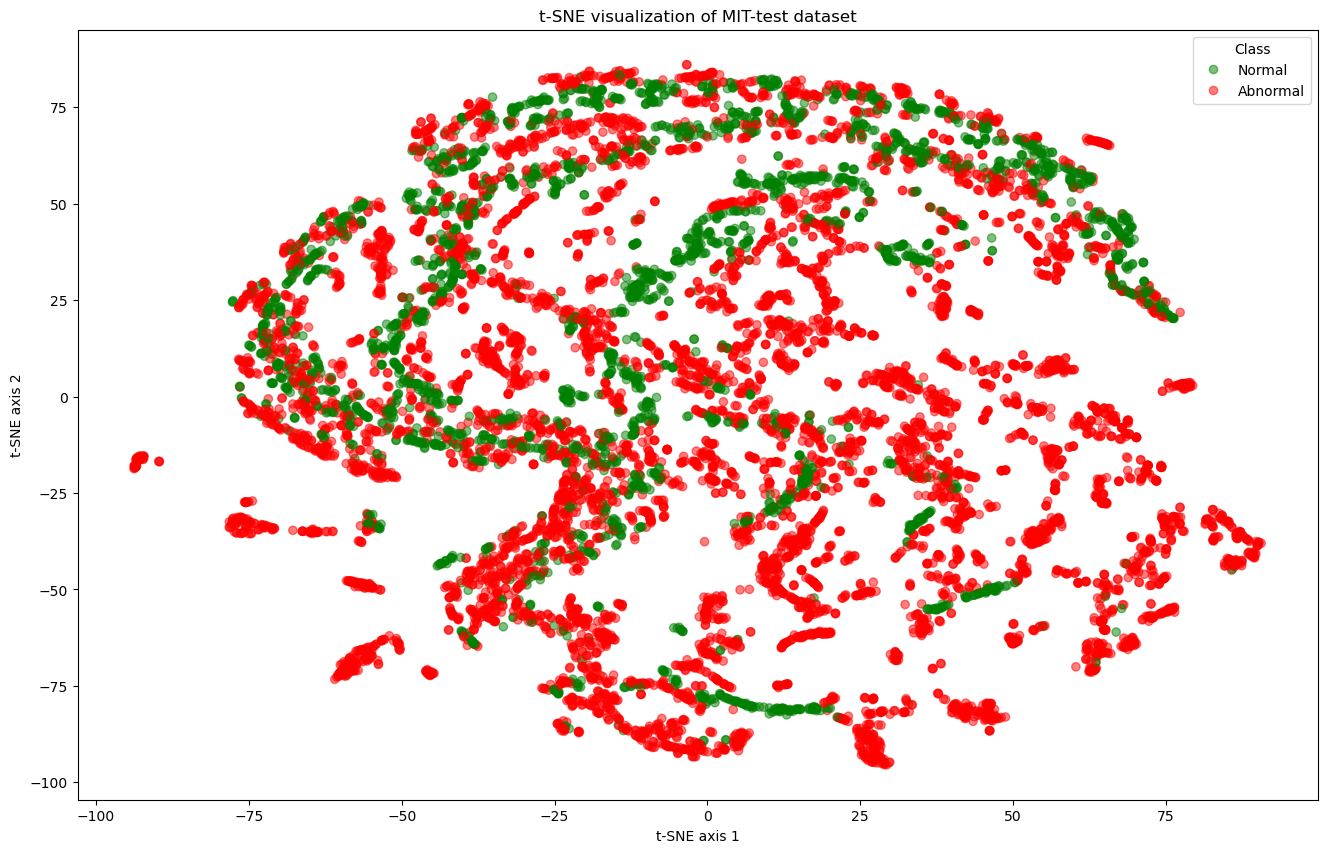

In [37]:
from matplotlib.colors import ListedColormap
# Separate features and labels
features = ptbdb_train.iloc[:, :-1]
labels = ptbdb_train.iloc[:, -1]

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(features_pca)

# Plot the results
plt.figure(figsize=(16,10))
unique_labels = labels.unique()
label_to_number = {
    0: 0,
    1: 1
}
colors = labels.map(label_to_number)

# Define your discrete color scale
color_discrete_scale = ['green','red']

# Create a ListedColormap object with the defined colors
cmap = ListedColormap(color_discrete_scale[:len(unique_labels)])

scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=cmap, alpha=0.5)
plt.title('t-SNE visualization of MIT-test dataset')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')

# Create a legend with the correct labels
handles, _ = scatter.legend_elements()
plt.legend(handles, [ 'Normal', 'Abnormal',], title='Class')

plt.show()


# Perform t_SNE in test set

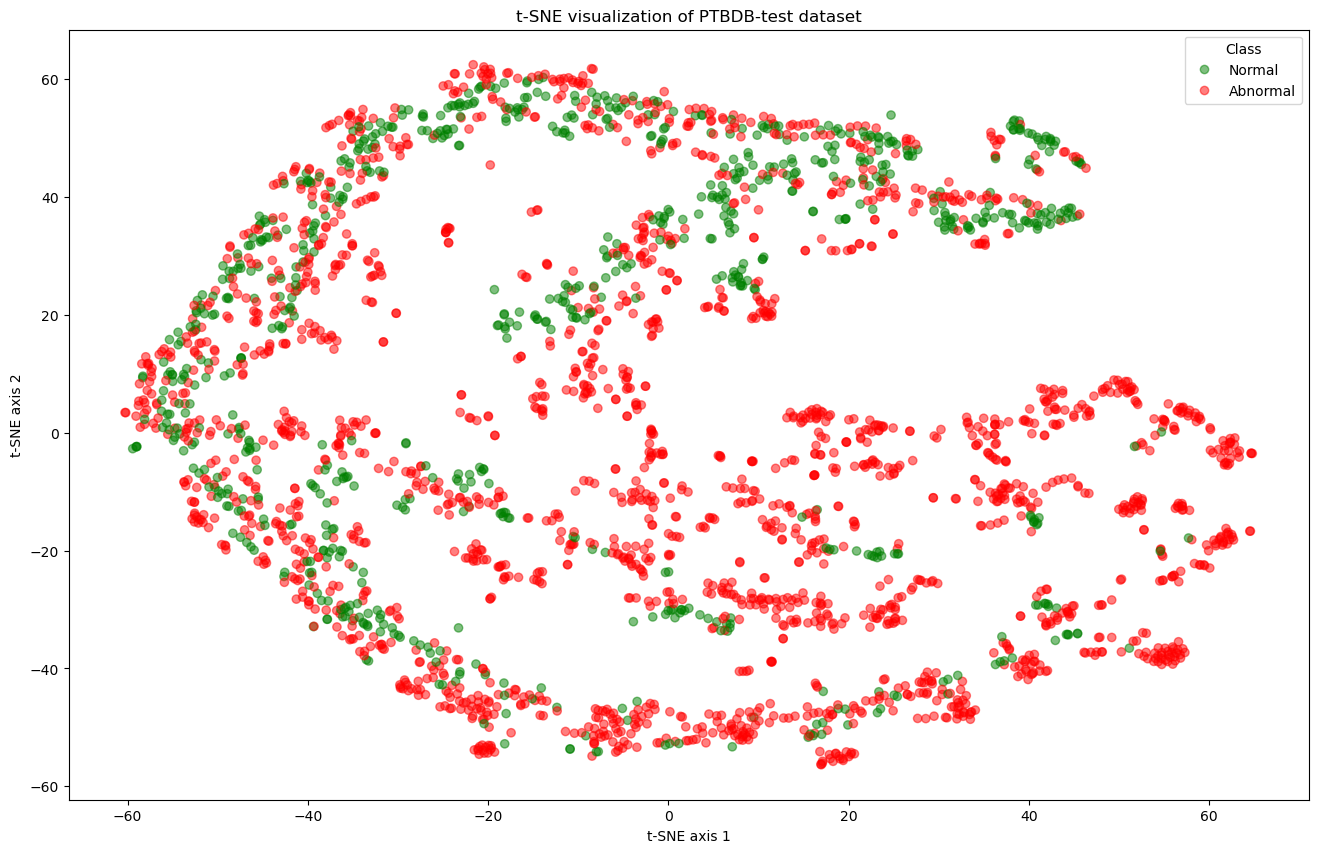

In [38]:
# Separate features and labels
features = ptbdb_test.iloc[:, :-1]
labels = ptbdb_test.iloc[:, -1]

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

# Perform t-SNE
tsne_results = tsne.fit_transform(features_pca)

# Plot the results
plt.figure(figsize=(16,10))
unique_labels = labels.unique()
label_to_number = {
    0: 0,
    1: 1
}
colors = labels.map(label_to_number)

# Define your discrete color scale
color_discrete_scale = ['green', 'red']

# Create a ListedColormap object with the defined colors
cmap = ListedColormap(color_discrete_scale[:len(unique_labels)])

scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=cmap, alpha=0.5)
plt.title('t-SNE visualization of PTBDB-test dataset')
plt.xlabel('t-SNE axis 1')
plt.ylabel('t-SNE axis 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Normal', 'Abnormal'], title='Class')
plt.show()


# Perform UMAP in training set (UMAP does not work for me, HELP!)

In [31]:
# from umap import UMAP

# # Drop target column from the training data
# features = ptbdb_train.drop(columns=['target'])

# # Apply UMAP
# umap_model = UMAP(n_components=2, random_state=42)  # Instantiate UMAP model
# df_umap = umap_model.fit_transform(features)  # Fit and transform the data

# # Define color mapping for target labels
# label_to_color = {0: 'red', 1: 'green'}  # Assuming 0 is Abnormal, 1 is Normal
# colors = ptbdb_train['target'].map(label_to_color)

# # Create the plot
# plt.figure(figsize=(16, 10))

# # Scatter plot of UMAP results
# scatter = plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, alpha=0.5)

# # Create a custom legend
# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Abnormal'),
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Normal')
# ]

# plt.title('UMAP Visualization of PTBDB Train Dataset')
# plt.xlabel('UMAP Axis 1')
# plt.ylabel('UMAP Axis 2')
# plt.legend(handles=handles, title='Class')
# plt.show()

# Perform UMAP in test set

In [32]:
# from umap import UMAP
# # Drop target column from test data
# features = ptbdb_test.drop(columns=['target'])

# # Apply UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# df_umap = umap_model.fit_transform(features)

# # Get unique labels and create a mapping
# unique_labels = ptbdb_test['target'].unique()
# label_to_color = {0: 'red', 1: 'green'}
# colors = ptbdb_test['target'].map(label_to_color)

# # Create the plot
# plt.figure(figsize=(16, 10))

# # Scatter plot of UMAP results
# scatter = plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors, cmap='viridis', alpha=0.5)

# # Create a custom legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Abnormal'),
#            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Normal')]

# plt.title('UMAP Visualization of PTBDB Test Dataset')
# plt.xlabel('UMAP Axis 1')
# plt.ylabel('UMAP Axis 2')
# plt.legend(handles=handles, title='Class')
# plt.show()

# Prepare Data for modeling and Preprocessing

In [40]:
num_cases_target_1 = ptbdb_train['target'].value_counts()[1] # [1] =  Abnormal
print("1 = Abnormal:", num_cases_target_1)

num_cases_target_0 = ptbdb_train['target'].value_counts()[0] # [0] = Normal
print("0 = Normal:",num_cases_target_0) # Attention: The Coding for target is the same with mit now!!!!!!

1 = Abnormal: 8402
0 = Normal: 3234


# load and split cleaned data

Class distribution in training
 target
1    0.724366
0    0.275634
Name: proportion, dtype: float64

Class distribution in test
 target
1    0.712126
0    0.287874
Name: proportion, dtype: float64




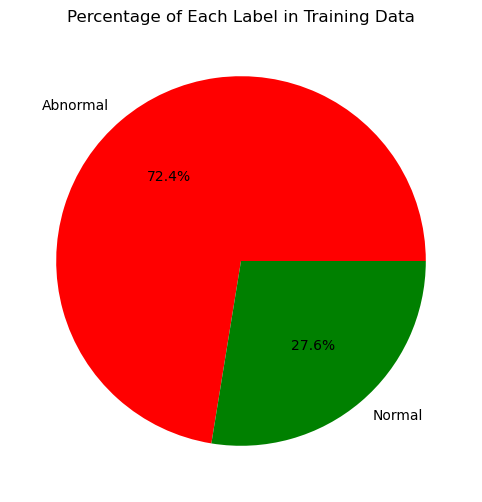

In [43]:
# File paths
train_file_path = 'ptbdb_train_clean.csv'
test_file_path = 'ptbdb_test_clean.csv'

# If the cleaned data files do not exist, save them
# if not os.path.isfile(train_file_path) or not os.path.isfile(test_file_path):
    # Read the data
    # Encode the labels
ptbdb_train['target'] = ptbdb_train['target'].replace({'Normal': 0, 'Abnormal': 1})
ptbdb_test['target'] = ptbdb_test['target'].replace({'Normal': 0, 'Abnormal': 1})

    # Save cleaned data
    # ptbdb_train.to_csv(train_file_path, index=False)
    # ptbdb_test.to_csv(test_file_path, index=False)
# else:
#     print("Cleaned data files already exist.")

# Read cleaned data
# try:
#     ptbdb_train = pd.read_csv(train_file_path, header=0)
#     ptbdb_test = pd.read_csv(test_file_path, header=0)
# except FileNotFoundError:
#     print(f"Error: The file {train_file_path} or {test_file_path} does not exist.")
    # Optionally, add code to handle this case, e.g., exit or retry

# Show the distribution of the two classes
print('Class distribution in training\n', ptbdb_train['target'].value_counts(normalize=True))
print('\nClass distribution in test\n', ptbdb_test['target'].value_counts(normalize=True))
print('\n')

# Plot a pie chart for training data class distribution
label_counts = ptbdb_train['target'].value_counts(normalize=True)
colors = ['red', 'green']
labels = ['Abnormal', 'Normal']

plt.figure(figsize=(10, 6))
plt.pie(label_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of Each Label in Training Data')
plt.show()


In [44]:
# Split the data into features (X) and target (y)
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']

X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']

In [45]:
from scipy.stats import kstest

normal_vars = []
non_normal_vars = []

# Iterate over each column in the dataset
for i in range(X_train.shape[1]):  # Loop through all columns
    stat, p = kstest(X_train.iloc[:, i], 'norm')
    
    if p > 0.05:
        normal_vars.append(i)
        print(f'Variable {i} follows a normal distribution (p-value: {p:.5f})')
    else:
        non_normal_vars.append(i)
        print(f'Variable {i} does NOT follow a normal distribution (p-value: {p:.5f})')

# Summary of results
print("\nSummary:")
if len(normal_vars) == X_train.shape[1]:
    print("All variables follow a normal distribution.")
elif len(non_normal_vars) == X_train.shape[1]:
    print("None of the variables follow a normal distribution.")
else:
    print(f"{len(normal_vars)} out of {X_train.shape[1]} variables follow a normal distribution.")
    print(f"{len(non_normal_vars)} out of {X_train.shape[1]} variables do NOT follow a normal distribution.")

print("Since our variables do not follow a normal distribution, it is advisable to use scaling methods such as MinMaxScaler or RobustScaler, which are better suited for data that does not conform to a normal distribution.")


Variable 0 does NOT follow a normal distribution (p-value: 0.00000)
Variable 1 does NOT follow a normal distribution (p-value: 0.00000)
Variable 2 does NOT follow a normal distribution (p-value: 0.00000)
Variable 3 does NOT follow a normal distribution (p-value: 0.00000)
Variable 4 does NOT follow a normal distribution (p-value: 0.00000)
Variable 5 does NOT follow a normal distribution (p-value: 0.00000)
Variable 6 does NOT follow a normal distribution (p-value: 0.00000)
Variable 7 does NOT follow a normal distribution (p-value: 0.00000)
Variable 8 does NOT follow a normal distribution (p-value: 0.00000)
Variable 9 does NOT follow a normal distribution (p-value: 0.00000)
Variable 10 does NOT follow a normal distribution (p-value: 0.00000)
Variable 11 does NOT follow a normal distribution (p-value: 0.00000)
Variable 12 does NOT follow a normal distribution (p-value: 0.00000)
Variable 13 does NOT follow a normal distribution (p-value: 0.00000)
Variable 14 does NOT follow a normal distrib

# Finding the best Rescaling method

In [37]:
# Define recommended scalers
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "None": None,
}

# Define base models to evaluate
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42), # even if desision tree and all other tree-based models do not need scaling, we will apply scaling to all models to have a fair comparison
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1),
}

def evaluate_scalers(X, y, scalers, models):
    results = {}
    for scaler_name, scaler in scalers.items():
        print(f"Scaler: {scaler_name}", end="\n\n")

        if scaler is None: 
            X_scaled = X.to_numpy()
        else: 
            X_scaled = scaler.fit_transform(X)

        skf = StratifiedKFold(n_splits=5)

        for model_name, model in models.items():
            f_score = []
            print(f"Model: {model_name}", end="\n\n")

            for train_index, test_index in skf.split(X_scaled, y):
                X_train_, y_train_ = X_scaled[train_index], y[train_index]
                X_test_, y_test_ = X_scaled[test_index], y[test_index]

                model.fit(X_train_, y_train_)

                y_pred_ = model.predict(X_test_)

                f_score.append(f1_score(y_test_, y_pred_))

            mean_f1_score = np.mean(f_score)
            print("The scores: ", end="\n\n")
            print([round(f, 2) for f in f_score], end="\n\n")
            print('F1-Score mean=%.5f' % (mean_f1_score), end="\n\n")

            if scaler_name not in results:
                results[scaler_name] = {}
            results[scaler_name][model_name] = mean_f1_score
    return results

# Apply evaluation
results = evaluate_scalers(X_train, y_train, scalers, models)
# Summarize the results
for scaler_name, model_scores in results.items():
    print(f"Scaler: {scaler_name}")
    for model_name, score in model_scores.items():
        print(f"  Model: {model_name}, F1-Score mean: {score:.5f}")
    print("\n")


Scaler: StandardScaler

Model: LogisticRegression

The scores: 

[0.84, 0.84, 0.84, 0.86, 0.83]

F1-Score mean=0.84091

Model: Decision Tree

The scores: 

[0.94, 0.94, 0.94, 0.94, 0.94]

F1-Score mean=0.93958

Model: SVM

The scores: 

[0.91, 0.9, 0.91, 0.92, 0.91]

F1-Score mean=0.91129

Model: KNN

The scores: 

[0.94, 0.95, 0.94, 0.95, 0.95]

F1-Score mean=0.94589

Scaler: MinMaxScaler

Model: LogisticRegression

The scores: 

[0.83, 0.83, 0.84, 0.85, 0.83]

F1-Score mean=0.83558

Model: Decision Tree

The scores: 

[0.94, 0.94, 0.94, 0.94, 0.94]

F1-Score mean=0.93958

Model: SVM

The scores: 

[0.9, 0.89, 0.9, 0.91, 0.9]

F1-Score mean=0.90192

Model: KNN

The scores: 

[0.95, 0.95, 0.95, 0.96, 0.95]

F1-Score mean=0.94944

Scaler: RobustScaler

Model: LogisticRegression

The scores: 

[0.84, 0.84, 0.84, 0.86, 0.83]

F1-Score mean=0.84067

Model: Decision Tree

The scores: 

[0.94, 0.94, 0.94, 0.94, 0.94]

F1-Score mean=0.93958

Model: SVM

The scores: 

[0.84, 0.83, 0.85, 0.86, 

# Applying the best rescaling method

In [38]:
# Determine the best scaler based on the highest average F1-score
best_scaler_name = max(results, key=lambda k: np.mean(list(results[k].values())))
best_scaler = scalers[best_scaler_name]
print(f"The best scaler is: {best_scaler_name}")

The best scaler is: StandardScaler


In [39]:
# Fit the best scaler on the training data and transform it
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


# Convert the numpy arrays to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Finding the best resampling method

In [ ]:
# When dealing with imbalanced datasets, especially those that reflect real-world scenarios,
# it’s important to use both resampling methods and appropriate loss functions to improve model performance.

def crossvalidation(X, y, models):
    resampling_methods = {
        "SMOTE": SMOTE(),
        "Oversampling": RandomOverSampler(sampling_strategy='not majority'),
        "Undersampling": RandomUnderSampler(sampling_strategy='majority'),
        "None": None,
    }

    skf = StratifiedKFold(n_splits=5)
    results = {}

    for name, resample in resampling_methods.items():
        print(name, end="\n\n")
        results[name] = {}

        for model_name, model in models.items():
            f_score = []
            print(f"Model: {model_name}", end="\n\n")

            for train_index, test_index in skf.split(X, y):
                X_train_, y_train_ = X.loc[train_index], y.loc[train_index]
                X_test_, y_test_ = X.loc[test_index], y.loc[test_index]

                if name == "BalancedRandomForest" or name == "None":
                    model.fit(X_train_, y_train_)
                else:
                    X_train_resampled, y_train_resampled = resample.fit_resample(X_train_, y_train_)
                    model.fit(X_train_resampled, y_train_resampled)

                y_pred_ = model.predict(X_test_)

                f_score.append(f1_score(y_test_, y_pred_))

            results[name][model_name] = np.mean(f_score)
            print("The scores: ", end="\n\n")
            print([round(f, 2) for f in f_score], end="\n\n")
            print('F1-Score mean=%.5f' % (np.mean(f_score)), end="\n\n")

    return results, resampling_methods

models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(class_weight='balanced', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)
}

# Apply cross-validation with resampling
results_resample, resampling_methods = crossvalidation(X_train_scaled, y_train, models)


SMOTE

Model: LogisticRegression

The scores: 

[0.84, 0.83, 0.84, 0.86, 0.83]

F1-Score mean=0.84099

Model: Tree

The scores: 

[0.94, 0.93, 0.94, 0.93, 0.94]

F1-Score mean=0.93637

Model: SVM



# Finding and Applying the best Resampling method

In [39]:
# Compare results
print("Results with Resampling:")
for method, result in results_resample.items(): 
    print(f"{method}: {result}")

# Determine the best resampling method
best_method = max(results_resample, key=lambda k: np.mean(list(results_resample[k].values())))
print(f"\nBest Resampling Method: {best_method}")

# Determine the best performing model under the best resampling method
best_model = max(results_resample[best_method], key=results_resample[best_method].get)
best_score = results_resample[best_method][best_model]

print(f"\nBest Performing Model: {best_model} with a score of {best_score:.4f} using the {best_method} resampling method.")

# Apply the best resampling method to the entire dataset
best_resampler = resampling_methods[best_method]


Results with Resampling:
SMOTE: {'LogisticRegression': 0.8398228697842004, 'Tree': 0.9334179695688951, 'SVM': 0.9322407701967009, 'KNN': 0.9251840546988935}
Oversampling: {'LogisticRegression': 0.8372332494998693, 'Tree': 0.9412468389490714, 'SVM': 0.9282183419692803, 'KNN': 0.9286495337573818}
Undersampling: {'LogisticRegression': 0.8334358487483879, 'Tree': 0.9160827910174852, 'SVM': 0.8912072061004448, 'KNN': 0.8855726933613133}

Best Resampling Method: Oversampling

Best Performing Model: Tree with a score of 0.9412 using the Oversampling resampling method.


# Same process for Ensamble Models
but without Scaling since we apply only tree-based models which do not need scaling and without Sampling, because Ensamble methods have their own strategies.

In [40]:
# Define ensemble models to evaluate
ensemble_models = {
    "Balanced Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42)
}

# Evaluate ensemble models without scaling or resampling
def evaluate_models(X, y, models):
    results = {}
    skf = StratifiedKFold(n_splits=5)

    for model_name, model in models.items():
        f_score = []
        print(f"Model: {model_name}", end="\n\n")

        for train_index, test_index in skf.split(X, y):
            X_train_, y_train_ = X.loc[train_index], y.loc[train_index]
            X_test_, y_test_ = X.loc[test_index], y.loc[test_index]

            model.fit(X_train_, y_train_)

            y_pred_ = model.predict(X_test_)

            f_score.append(f1_score(y_test_, y_pred_))

        mean_f1_score = np.mean(f_score)
        print("The scores: ", end="\n\n")
        print([round(f, 2) for f in f_score], end="\n\n")
        print('F1-Score mean=%.5f' % (mean_f1_score), end="\n\n")

        results[model_name] = mean_f1_score
    return results

# Apply evaluation without resampling
results_ensemble = evaluate_models(X_train, y_train, ensemble_models)

# Summarize the results
for model_name, score in results_ensemble.items():
    print(f"Model: {model_name}, F1-Score mean: {score:.5f}")
print("\n")


Model: Balanced Random Forest

The scores: 

[0.98, 0.97, 0.98, 0.98, 0.98]

F1-Score mean=0.97753

Model: Gradient Boosting

The scores: 

[0.95, 0.95, 0.95, 0.96, 0.95]

F1-Score mean=0.95212

Model: XGBoost



c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:09:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not u

The scores: 

[0.98, 0.98, 0.98, 0.99, 0.98]

F1-Score mean=0.98389

Model: LightGBM

[LightGBM] [Info] Number of positive: 6740, number of negative: 2568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41701
[LightGBM] [Info] Number of data points in the train set: 9308, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6740, number of negative: 2568
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41709
[LightGBM] [Info] Number of data points in the train set: 9308, number of used features: 183
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> in

In [44]:
# Summarize the results
print("Results for Ensamble Models on PTB:")
for model_name, score in results_ensemble.items():
    print(f"Model: {model_name}, F1-Score mean: {score:.5f}")
print("\n")

# Determine the best performing model
best_model = max(results_ensemble, key=results_ensemble.get)
best_score = results_ensemble[best_model]
print(f"The best performing model is: {best_model} with an F1-Score of {best_score:.5f}")

Results for Ensamble Models on PTB:
Model: Balanced Random Forest, F1-Score mean: 0.97753
Model: Gradient Boosting, F1-Score mean: 0.95212
Model: XGBoost, F1-Score mean: 0.98389
Model: LightGBM, F1-Score mean: 0.97938


The best performing model is: XGBoost with an F1-Score of 0.98389


In [ ]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())